In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import math
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [3]:
def make_submission(X, net, fname="my_submission.csv"):
    X = torch.from_numpy(X).float().cuda()
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X.shape[0]):
            y_h = net.forward(X[i], train=False)
            y = torch.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [4]:
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    X_test = torch.from_numpy(X_test).float().cuda()
    Y_test = torch.from_numpy(Y_test).float().cuda()
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i], train=False)
        y_h = y_h.cpu().numpy()
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [5]:
# Read data
train_data = None
test_data = None
encoder = OneHotEncoder()

with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)

X_train, X_validation, Y_train, Y_validation = train_test_split(train_data['data'], train_data['target'])
,
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))
Y_validation_oh = np.array(list(map(lambda x : encoder.transform(x), Y_validation)))

# Normolize data
mean = np.mean(X_train, axis=0)
std  = np.std(X_train, axis=0)

X_train   = (X_train - mean)/(std + 1e-15)
X_validation = (X_validation - mean)/ (std + 1e-15)

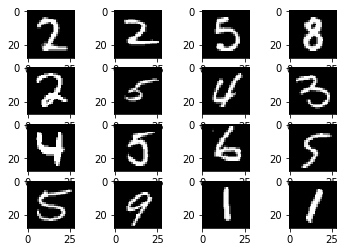

In [6]:
n = 4
for i in range(n * n):
    plt.subplot(n,n,i + 1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [7]:
class Dense:
    def __init__(self, in_size, out_size, lambd = 0.0):
        self.lambd = lambd
        
        self.W = torch.randn(out_size, in_size).cuda() * math.sqrt(2 / (out_size + in_size))
        self.b = torch.zeros(out_size, ).cuda() 
        
    def forward(self, x, train=True):
        self.x = x
        return torch.matmul(self.W, x) + self.b
    
    def get_reg_loss(self):
        return self.lambd * (torch.norm(a,(self.W, 2)))
    
    def backward(self, dz, lr):
    
        self.dW = torch.ger(dz, self.x) + self.lambd * self.W
        self.db = dz

        self.dx = torch.matmul(self.W.t(), dz) 
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        return self.dx

In [8]:
class ReLU:
    def forward(self, x, train=True):
        self.x = x
        return torch.relu(x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz
    

In [9]:
class Dropout:
    def __init__(self, p):
        self.p = p
        self.train = True
    
    def forward(self, x, train=True):
        if not train:
            self.mask = torch.ones(*x.shape).cuda()
            return x
        
        self.mask = torch.rand(*x.shape).ge(self.p).float().cuda() * (1 / (1 - self.p))
        return x * self.mask
        
    def backward(self, dz, lr):
        return dz * self.mask

In [10]:
class CrossEntropy:
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat  = y_hat
        return -1 * torch.sum( y_true * torch.log (y_hat + 1e-10))
    
    def backward(self, dz, lr):
        return -1 * dz * self.y_true / (self.y_hat + 1e-10)

In [11]:
class Softmax:
    def forward(self, x, train=True):
        self.x = x
        exps = torch.exp(x - torch.max(x))
        return exps / exps.sum()
    
    def backward(self, dz, lr):
        sm  = self.forward(self.x).cuda()
        return torch.matmul(sm * torch.t(torch.eye(self.x.shape[0]).cuda() - sm), dz)
    

In [12]:
class MnistNet:
    def __init__(self, layers, learning_rate, lambd = 0):
        self.layers = layers
        self.learning_rate = learning_rate
        self.lambd = lambd
        
    def forward(self, x, train=True):
        self.x = x
        net = x
        for i in range(len(self.layers)):
            net = self.layers[i].forward(net, train)
        return net
    
    def backward(self, dz):
        for i in range(len(self.layers)):
            dz  = self.layers[len(self.layers) - i - 1].backward(dz, self.learning_rate)
        return dz
    
    def fit (self, X_train, Y_train, X_valid, Y_valid, num_epochs):
        X_train = torch.from_numpy(X_train).float().cuda()
        Y_train = torch.from_numpy(Y_train).float().cuda()
        
        X_valid = torch.from_numpy(X_valid).float().cuda()
        Y_valid = torch.from_numpy(Y_valid).float().cuda()
        
        m1 = X_train.shape[0]
        m2 = X_valid.shape[0]
        
        loss = CrossEntropy() 
        cost_train = []
        cost_valid = []
        
        lr = self.learning_rate
        for iter in range(num_epochs):
            print("Epoch: ", iter)
            
            # Learning rate decay
            lr *= 0.985
            L_acc = 0
            for i in range(m1):
                x = X_train[i]
                y = Y_train[i]
                
                y_h = self.forward(x)
                L1 = loss.forward(y, y_h)/m1
                L_acc += L1.item()
                
                dz = loss.backward(1, lr)
                self.backward(dz)
                
            cost_train.append(L_acc) 
            print("Train cost: ", L_acc)
            
            L_acc = 0
            for i in range(m2):
                x = X_valid[i]
                y = Y_valid[i]
                
                y_h = self.forward(x)
                L1 = loss.forward(y, y_h)/m2
                L_acc += L1.item()
                
            cost_valid.append(L_acc) 
            print("valid cost: ", L_acc)
               
        plt.plot(cost_valid)
        plt.plot(cost_train)

In [13]:
# Define model architecture
net = MnistNet([Dense(784, 460, 0.003), ReLU(), Dropout(0.3),  Dense(460, 10, 0.003),  Softmax()], 0.0025)

Epoch:  0
Train cost:  0.33962966212351503
valid cost:  0.2748691945880313
Epoch:  1
Train cost:  0.18787145904035765
valid cost:  0.2147099352456352
Epoch:  2
Train cost:  0.15018577702209981
valid cost:  0.18647783909961171
Epoch:  3
Train cost:  0.1266132789085386
valid cost:  0.17304729225460455
Epoch:  4
Train cost:  0.11944333021700923
valid cost:  0.16716216303984882
Epoch:  5
Train cost:  0.10893776140926065
valid cost:  0.16520821664771
Epoch:  6
Train cost:  0.10804310794430858
valid cost:  0.16783585563705816
Epoch:  7
Train cost:  0.10784365881694472
valid cost:  0.16062607136112095
Epoch:  8
Train cost:  0.10546820901089096
valid cost:  0.1581393123110364
Epoch:  9
Train cost:  0.10045454623126764
valid cost:  0.14933069597700685
Epoch:  10
Train cost:  0.10589779322213509
valid cost:  0.14595369913908124
Epoch:  11
Train cost:  0.09702106024786027
valid cost:  0.15584869013199915
Epoch:  12
Train cost:  0.1029866571590848
valid cost:  0.1523864469116063
Epoch:  13
Train c

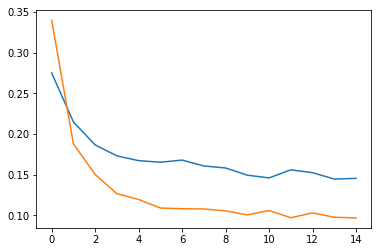

In [14]:
# Train model
net.fit(X_train, Y_train_oh, X_validation, Y_validation_oh, 15)

In [15]:
# Analyze results
train_acc = compute_acc(X_train, Y_train, net)
validation_acc = compute_acc(X_validation, Y_validation, net)

print("Train accuracy: ", train_acc)
print("Validation accuracy: ", validation_acc)

Train accuracy:  0.9846603174603175
Validation accuracy:  0.9666285714285714


In [16]:
# Submit predictions
X_test = test_data ['data']
X_test   = (X_test - mean)/(std + 1e-15)
make_submission(X_test, net)